# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import skimage
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
tf.random.set_seed(30)

Default GPU Device: /device:GPU:0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('C:/Users/sebas/Case Study RNN/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/sebas/Case Study RNN/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [num for num in range(0,15,1)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = skimage.io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = skimage.transform.resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = skimage.io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = skimage.transform.resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/sebas/Case Study RNN/Project_data/train'
val_path = 'C:/Users/sebas/Case Study RNN/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. You might want to use `TimeDistributed`, `GRU` and other RNN structures after doing transfer learning. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed,Conv2D, Input, Activation, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
    
base_model = InceptionV3(include_top=False, weights='imagenet', pooling="avg", input_shape=(120,120,3))
x = base_model.output
features = Dense(64, activation='relu')(x)
cnn = Model(inputs=base_model.input, outputs=features)
        
model = Sequential()
model.add(TimeDistributed(cnn,input_shape=(15,120,120,3)))  
model.add(GRU(16, return_sequences=True))
model.add(GRU(8))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
#sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 64)            21933920  
_________________________________________________________________
gru (GRU)                    (None, 15, 16)            3936      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 21,938,597
Trainable params: 21,904,165
Non-trainable params: 34,432
_______________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only= True, save_weights_only= True, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    workers=1, 
                    initial_epoch=0)

Source path =  C:/Users/sebas/Case Study RNN/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - 105s 1s/step - loss: 1.5780 - categorical_accuracy: 0.2926 - val_loss: 1.6247 - val_categorical_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 1.62467, saving model to model_init_conv_lstm_2022-07-1120_20_44.345298\model-00001-1.57802-0.29261-1.62467-0.19000.h5
Epoch 2/20
83/83 [==============================] - 77s 939ms/step - loss: 1.5890 - categorical_accuracy: 0.2685 - val_loss: 1.6601 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.62467
Epoch 3/20
83/83 [==============================] - 76s 920ms/step - loss: 1.5625 - categorical_accuracy: 0.2941 - val_loss: 1.6043 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss improved from 1.62467 to 1.60429, saving model to model_init_conv_lstm_2022-07-1120_20_44.345298\model-00003-1.56255-0.29412-1.60429-0.25000.h5
Epoch 4/20
83/83 [====================

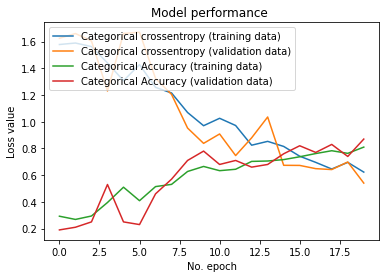

In [12]:
import matplotlib.pyplot as plt
# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['categorical_accuracy'], label='Categorical Accuracy (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Categorical Accuracy (validation data)')
plt.title('Model performance ')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()